In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Read the CSV file
df = pd.read_csv('FT_History.csv')

df.head()

,Symbol,Quantity,Price,Action,Description,TradeDate,SettledDate,Interest,Amount,Commission,Fee,CUSIP,RecordType
0,,0.0,NaN,Other,ACH DEPOSIT SEN(20230801230870),2023-08-01,2023-08-01,0.0,1500.00,0.0,0.0,,Financial
1,SPY,1.0,453.3000,BUY,SPDR S&P 500 ETF TRUST UNSOLICITED ...,2023-08-02,2023-08-04,0.0,-453.30,0.0,0.0,78462F103,Trade
2,TSLA,1.0,255.6000,BUY,TESLA INC COMMON STOCK ...,2023-08-02,2023-08-04,0.0,-255.60,0.0,0.0,88160R101,Trade
3,DIS,2.0,85.8799,BUY,WALT DISNEY CO UNSOLICITED ...,2023-08-03,2023-08-07,0.0,-171.76,0.0,0.0,254687106,Trade
4,,0.0,NaN,Other,ACH DEPOSIT SEN(20230803315888),2023-08-03,2023-08-03,0.0,3500.00,0.0,0.0,,Financial


In [3]:
class Transaction:
    def __init__(self, symbol, quantity, price, action, date):
        self.symbol = symbol
        self.quantity = quantity
        self.price = price
        self.action = action
        self.date = datetime.strptime(date, '%Y-%m-%d')


class Portfolio:
    def __init__(self):
        self.holdings = {}
        self.history = []
        self.cash = 0.0

    def process_transaction(self, transaction):
        symbol = transaction.symbol
        quantity = transaction.quantity
        price = transaction.price
        action = transaction.action

        if action == 'BUY':
            if symbol not in self.holdings:
                self.holdings[symbol] = {'quantity': 0, 'total_cost': 0}
            self.holdings[symbol]['quantity'] += quantity
            self.holdings[symbol]['total_cost'] += quantity * price
            self.cash -= quantity * price

        elif action == 'SELL' and symbol in self.holdings:
            self.holdings[symbol]['quantity'] -= quantity
            self.holdings[symbol]['total_cost'] -= quantity * price
            self.cash += quantity * price
            if self.holdings[symbol]['quantity'] <= 0:
                del self.holdings[symbol]

    def process_financial(self, amount):
        self.cash += amount

    def record_daily_balance(self, date):
        date = datetime.strptime(
            date, '%Y-%m-%d') if isinstance(date, str) else date
        daily_balance = next(
            (entry for entry in self.history if entry['date'] == date), None)
        if daily_balance:
            daily_balance['holdings'] = {k: v.copy()
                                         for k, v in self.holdings.items()}
            daily_balance['cash'] = self.cash
        else:
            self.history.append({
                'date': date,
                'holdings': {k: v.copy() for k, v in self.holdings.items()},
                'cash': self.cash
            })

    def get_history(self):
        return self.history

In [4]:
# Process the transactions
portfolio = Portfolio()
for _, row in df.iterrows():
    if pd.notna(row['Symbol']) and row['Action'] in ['BUY', 'SELL']:
        transaction = Transaction(
            symbol=row['Symbol'].strip(),
            quantity=abs(float(row['Quantity'])),
            price=float(row['Price']) if pd.notna(row['Price']) else 0.0,
            action=row['Action'],
            date=row['TradeDate']
        )
        portfolio.process_transaction(transaction)
    elif row['RecordType'] == 'Financial':
        amount = float(row['Amount'])
        portfolio.process_financial(amount)

    portfolio.record_daily_balance(row['TradeDate'])
    
# Get the history of the portfolio
history = portfolio.get_history()

In [5]:
# oldest_portfolio = history[:3]

# oldest_portfolio

In [6]:
latest_portfolio = history[-1]

latest_portfolio

{'date': datetime.datetime(2024, 8, 5, 0, 0),
 'holdings': {'SPY': {'quantity': 5.0, 'total_cost': 2348.27},
  'TSLA': {'quantity': 70.0, 'total_cost': 13874.125199999999},
  'TSM': {'quantity': 16.0332, 'total_cost': 1977.3762768569998},
  'AAPL': {'quantity': 5.0, 'total_cost': 885.8596},
  'QQQ': {'quantity': 7.0, 'total_cost': 3011.0397},
  'NVDA': {'quantity': 100.02477, 'total_cost': 8935.942495},
  'NVDL': {'quantity': 50.0, 'total_cost': 2003.3930999999998},
  'MSFT': {'quantity': 2.0, 'total_cost': 821.9798000000001},
  'META': {'quantity': 2.0, 'total_cost': 864.723},
  'AMZN': {'quantity': 6.23701, 'total_cost': 1090.564453099},
  'AMD': {'quantity': 13.00214, 'total_cost': 1994.128586},
  'SNOW': {'quantity': 5.0, 'total_cost': 628.3446},
  'CRWD': {'quantity': 3.8290699999999998, 'total_cost': 1010.533185772},
  'OKTA': {'quantity': 11.91484, 'total_cost': 1065.674975316}},
 'cash': 128.44212795599896}

In [7]:
def calculate_gains(symbol, quantity, total_cost, date=None):
    stock = yf.Ticker(symbol)
    date = date or datetime.today().strftime('%Y-%m-%d')
    date = datetime.strptime(date, '%Y-%m-%d')

    start_date = (date - timedelta(days=5)).strftime('%Y-%m-%d')
    end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')

    history = stock.history(start=start_date, end=end_date)['Close']
    if len(history) < 2:
        return {key: None for key in ['Current Price', 'Current Value', 'Day\'s Gain', 'Day\'s Gain %', 'Total Gain', 'Total Gain %']}

    latest_price = history.iloc[-1]
    previous_price = history.iloc[-2]

    current_value = quantity * latest_price
    previous_value = quantity * previous_price

    days_gain = current_value - previous_value
    days_gain_percent = (days_gain / previous_value) * \
        100 if previous_value != 0 else 0

    total_gain = current_value - total_cost
    total_gain_percent = (total_gain / total_cost) * \
        100 if total_cost != 0 else 0

    return {
        'Current Price': latest_price,
        'Current Value': current_value,
        'Day\'s Gain': days_gain,
        'Day\'s Gain %': days_gain_percent,
        'Total Gain': total_gain,
        'Total Gain %': total_gain_percent
    }


def get_portfolio_performance(date=None, print_results=True):
    if date is None:
        portfolio_on_date = latest_portfolio
        date_str = datetime.today().strftime('%Y-%m-%d')
    else:
        parsed_date = datetime.strptime(date, '%Y-%m-%d')
        # Find the closest date in history
        closest_date = min(history, key=lambda x: abs(
            x['date'] - parsed_date))['date']
        portfolio_on_date = next(
            (entry for entry in history if entry['date'] == closest_date), None)
        date_str = closest_date.strftime('%Y-%m-%d')

    results = {}
    for symbol, data in portfolio_on_date['holdings'].items():
        results[symbol] = calculate_gains(
            symbol, data['quantity'], data['total_cost'], date_str)

    df_results = pd.DataFrame(results).T
    df_results.index.name = 'Symbol'
    df_results = df_results.reset_index()

    df_results['Quantity'] = [portfolio_on_date['holdings']
                              [symbol]['quantity'] for symbol in df_results['Symbol']]
    df_results['Total Cost'] = [portfolio_on_date['holdings']
                                [symbol]['total_cost'] for symbol in df_results['Symbol']]

    column_order = ['Symbol', 'Quantity', 'Current Price', 'Current Value',
                    'Total Cost', 'Day\'s Gain', 'Day\'s Gain %', 'Total Gain', 'Total Gain %']
    df_results = df_results[column_order]

    df_results = df_results.sort_values(by='Symbol')

    total_portfolio_value = df_results['Current Value'].sum()
    total_days_gain = df_results['Day\'s Gain'].sum()
    total_days_gain_percent = (
        total_days_gain / total_portfolio_value) * 100 if total_portfolio_value != 0 else 0

    if print_results:
        print(df_results.to_string(index=False,
              float_format=lambda x: f'{x:.2f}'))
        print()
        print(f"Total Balance: ${total_portfolio_value:.2f}")
        print(f"Day's gain: ${total_days_gain:.2f} ({
              total_days_gain_percent:.2f}%)")
    else:
        return df_results, total_portfolio_value, total_days_gain, total_days_gain_percent


# Ensure all dates in history are converted to datetime objects
for entry in history:
    if isinstance(entry['date'], str):
        entry['date'] = datetime.strptime(entry['date'], '%Y-%m-%d')

In [8]:
get_portfolio_performance()

Symbol  Quantity  Current Price  Current Value  Total Cost  Day's Gain  Day's Gain %  Total Gain  Total Gain %
  AAPL      5.00         215.27        1076.35      885.86        9.80          0.92      190.49         21.50
   AMD     13.00         134.76        1752.12     1994.13      -20.33         -1.15     -242.01        -12.14
  AMZN      6.24         166.75        1040.02     1090.56        5.93          0.57      -50.54         -4.63
  CRWD      3.83         239.30         916.29     1010.53       -4.68         -0.51      -94.25         -9.33
  META      2.00         514.97        1029.94      864.72       10.68          1.05      165.22         19.11
  MSFT      2.00         406.37         812.74      821.98        7.36          0.91       -9.24         -1.12
  NVDA    100.02         104.99       10501.60     8935.94        2.00          0.02     1565.66         17.52
  NVDL     50.00          46.56        2327.75     2003.39       -7.25         -0.31      324.36         16.19
 

In [9]:
get_portfolio_performance('2023-09-10')

Symbol  Quantity  Current Price  Current Value  Total Cost  Day's Gain  Day's Gain %  Total Gain  Total Gain %
  AAPL      2.00         176.86         353.72      355.90      -10.66         -2.92       -2.18         -0.61
   AMD      2.00         106.59         213.18      202.08       -5.38         -2.46       11.10          5.49
   DIS     18.00          79.94        1438.91     1525.34       -7.32         -0.51      -86.43         -5.67
  PLTR     30.00          15.21         456.30      440.00       -2.70         -0.59       16.30          3.71
   QQQ      1.00         369.51         369.51      370.00       -2.66         -0.72       -0.49         -0.13
  SONY      2.00          85.23         170.46      165.80       -0.54         -0.32        4.66          2.81
   SPY      2.00         438.71         877.43      891.30       -2.70         -0.31      -13.87         -1.56
  TSLA      7.00         251.49        1760.43     1664.10       -3.01         -0.17       96.33          5.79
 

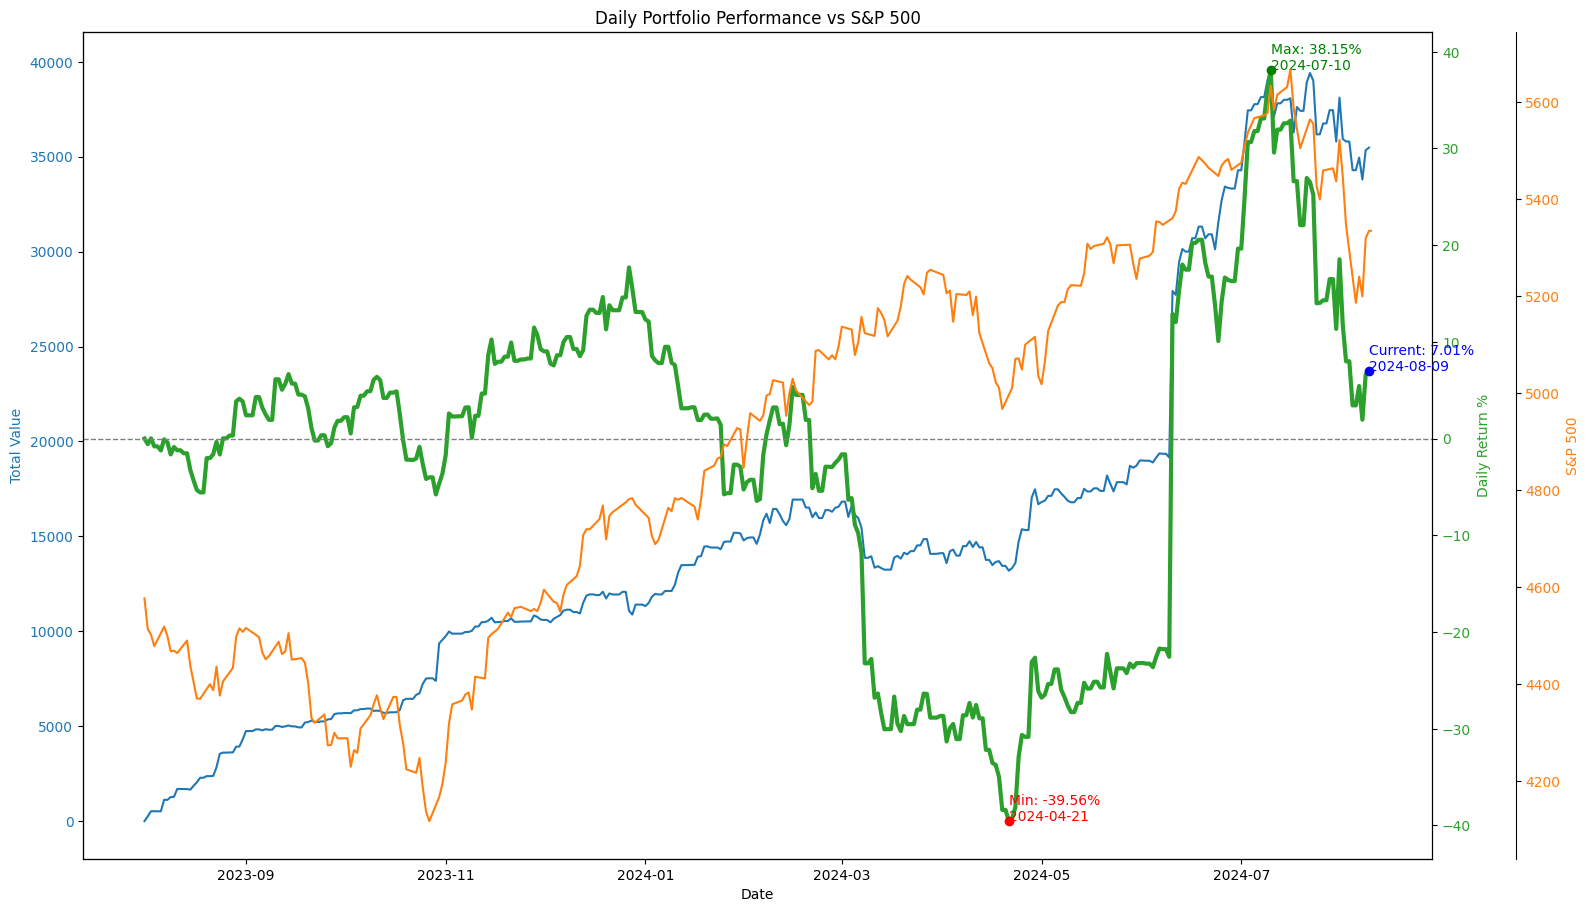

In [10]:
def get_closest_date(target_date, available_dates):
    return min(available_dates, key=lambda x: abs(x - target_date))


def fetch_symbol_history(symbols, start_date, end_date):
    data = {}
    for symbol in symbols:
        ticker = yf.Ticker(symbol)
        data[symbol] = ticker.history(start=start_date, end=end_date)[
            'Close'].tz_localize(None)
        if datetime.now().time() < datetime.strptime('16:00', '%H:%M').time():
            current_price = ticker.history(period='1d')['Close'].iloc[-1]
            data[symbol].loc[datetime.now()] = current_price
    return data


def calculate_daily_performance(history, symbol_data, exclude_etfs=None):
    exclude_etfs = exclude_etfs or ['QQQ', 'SPY', 'NVDL']
    daily_performance = []
    last_portfolio = history[-1]
    end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

    for date in pd.date_range(start=history[0]['date'], end=end_date):
        date = date.to_pydatetime()
        current_portfolio = next((entry for entry in reversed(
            history) if entry['date'] <= date), last_portfolio)

        total_value = total_cost = 0
        for symbol, data in current_portfolio['holdings'].items():
            if symbol in exclude_etfs:
                continue
            available_dates = symbol_data[symbol].index
            closing_price = symbol_data[symbol].loc[date if date in available_dates else get_closest_date(
                date, available_dates)]

            total_value += data['quantity'] * closing_price
            total_cost += data['total_cost']

        daily_return = total_value - total_cost
        daily_return_percent = (daily_return / total_cost) * \
            100 if total_cost != 0 else 0
        daily_performance.append({
            'date': date,
            'total_value': total_value,
            'daily_return': daily_return,
            'daily_return_percent': daily_return_percent
        })

    return daily_performance


def plot_daily_performance(daily_performance, sp500_data):
    dates = [entry['date'] for entry in daily_performance]
    total_values = [entry['total_value'] for entry in daily_performance]
    daily_return_percents = [entry['daily_return_percent']
                             for entry in daily_performance]

    fig, ax1 = plt.subplots(figsize=(16, 9))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Value', color='tab:blue')
    ax1.plot(dates, total_values, color='tab:blue', label='Total Value')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Daily Return %', color='tab:green')
    ax2.plot(dates, daily_return_percents,
             color='tab:green', label='Daily Return %', linewidth=3)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

    min_return = min(daily_return_percents)
    max_return = max(daily_return_percents)
    current_return = daily_return_percents[-1]

    for return_value, color, label in [(min_return, 'red', 'Min'), (max_return, 'green', 'Max'), (current_return, 'blue', 'Current')]:
        date = dates[daily_return_percents.index(return_value)]
        ax2.plot(date, return_value, 'o', color=color)
        ax2.text(date, return_value, f'{label}: {return_value:.2f}%\n{date.strftime("%Y-%m-%d")}',
                 fontsize=10, color=color, ha='left')

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('S&P 500', color='tab:orange')
    ax3.plot(sp500_data.index, sp500_data.values,
             color='tab:orange', label='S&P 500')
    ax3.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title('Daily Portfolio Performance vs S&P 500')
    plt.show()


# Ensure all dates in history are converted to datetime objects
for entry in history:
    if isinstance(entry['date'], str):
        entry['date'] = datetime.strptime(entry['date'], '%Y-%m-%d')

# Main execution
symbols = {symbol for entry in history for symbol in entry['holdings'].keys()}

start_date = history[0]['date'].strftime('%Y-%m-%d')
end_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
symbol_data = fetch_symbol_history(symbols, start_date, end_date)

# Fetch S&P 500 data
sp500_data = yf.Ticker('^GSPC').history(
    start=start_date, end=end_date)['Close'].tz_localize(None)
if datetime.now().time() < datetime.strptime('16:00', '%H:%M').time():
    sp500_current_price = yf.Ticker('^GSPC').history(period='1d')[
        'Close'].iloc[-1]
    sp500_data.loc[datetime.now()] = sp500_current_price

daily_performance = calculate_daily_performance(
    history, symbol_data, exclude_etfs=['QQQ', 'SPY', 'NVDL'])
    
plot_daily_performance(daily_performance, sp500_data)

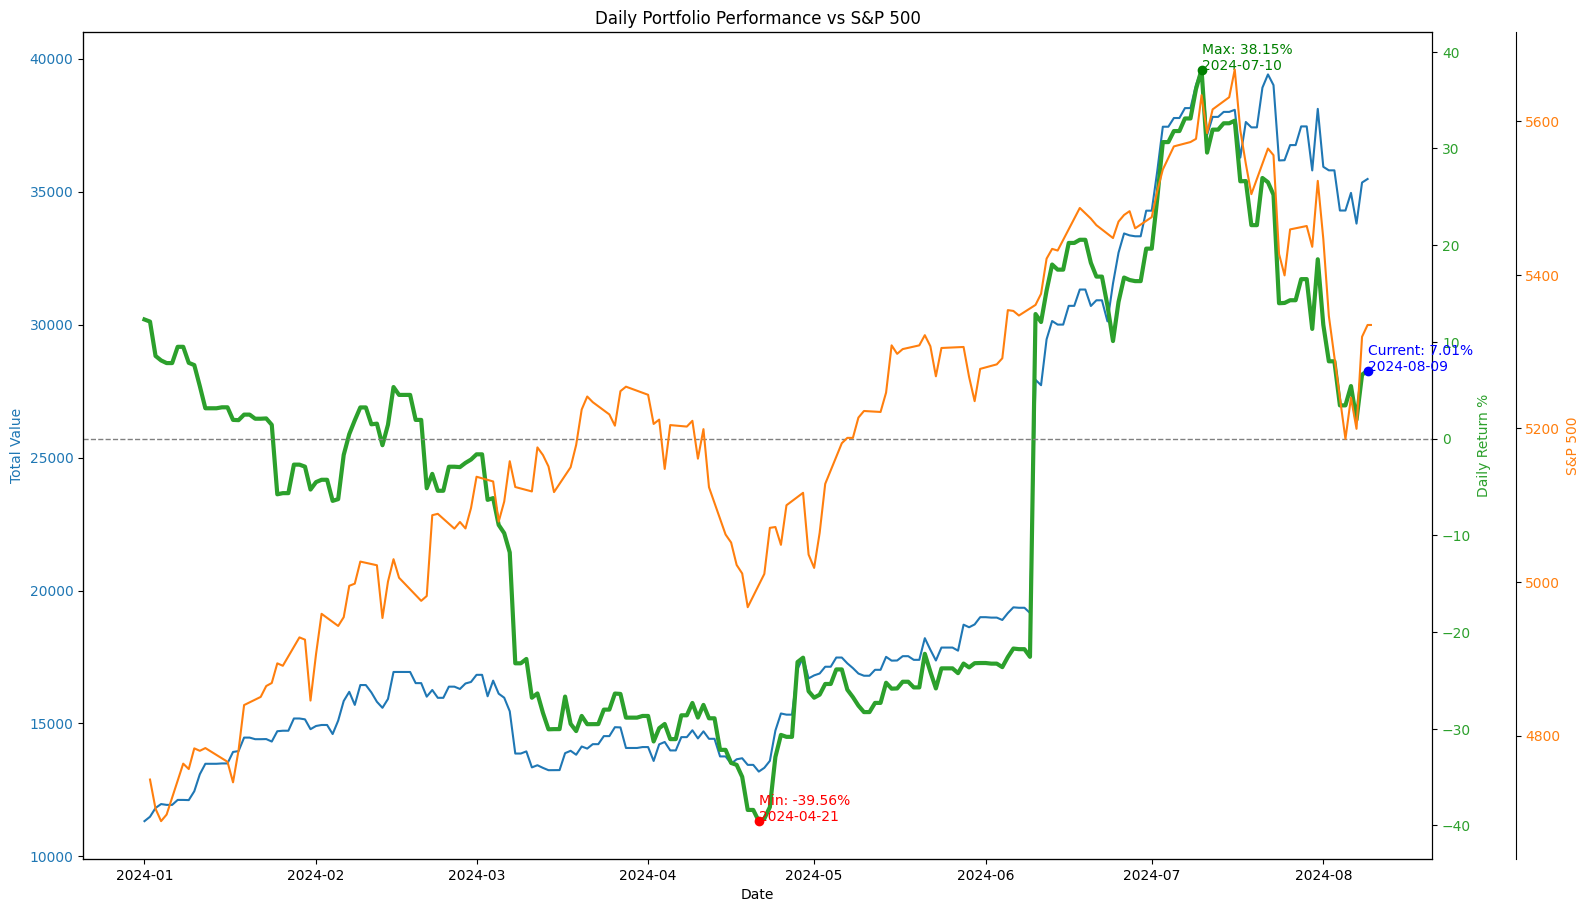

In [11]:
# Filter daily performance for year-to-date
current_year = datetime.now().year
ytd_performance = [
    entry for entry in daily_performance if entry['date'].year == current_year]

# Filter S&P 500 data for year-to-date
ytd_sp500_data = sp500_data[sp500_data.index.year == current_year]

# Plot year-to-date performance
plot_daily_performance(ytd_performance, ytd_sp500_data)

In [12]:
daily_performance[-3:]

[{'date': datetime.datetime(2024, 8, 7, 0, 0),
  'total_value': np.float64(33794.988992115475),
  'daily_return': np.float64(645.7368200714773),
  'daily_return_percent': np.float64(1.9479679864876445)},
 {'date': datetime.datetime(2024, 8, 8, 0, 0),
  'total_value': np.float64(35339.61969039887),
  'daily_return': np.float64(2190.3675183548694),
  'daily_return_percent': np.float64(6.607592554386757)},
 {'date': datetime.datetime(2024, 8, 9, 0, 0),
  'total_value': np.float64(35473.105457158505),
  'daily_return': np.float64(2323.8532851145064),
  'daily_return_percent': np.float64(7.0102736346924255)}]